In [1]:
import re
import string
import torch
import nltk
import unicodedata
import spacy
import random

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors

from snowballstemmer import stemmer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [ ]:
nltk.download('punkt')
nltk.download('omw')

In [2]:
#  -- Code from exercise 1 (improved) --  #

def cleaning_txt(data):
    data = re.sub(r'@\S+', '', data)
    data = re.sub(r'#','',data)
    return data

def cleaning_punctuations(data):
    translator = str.maketrans('', '', string.punctuation)
    return data.translate(translator)

def cleaning_repeating_char(data):
    return re.sub(r'(.)1+', r'1', data)

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def split_stacked_words(data):
    if not isinstance(data, str):
        return data
    pattern = re.compile(r'([α-ωά-ώ])([Α-ΩΆ-Ώ])', re.UNICODE)
    data = re.sub(pattern, r'\1 \2', data)  #Add a space
    return data

def remove_greek_numerals(data):
    # Define a regular expression pattern to match Greek numerals
    greek_numeral_pattern = re.compile(r'\b(?:Ένα|Δύο|Τρία|Τέσσερα|Πέντε|Έξι|Επτά|Οκτώ|Εννέα|Δέκα|Έντεκα|Δώδεκα|Δεκατρία|Δεκατέσσερα|Δεκαπέντε|Δεκαέξι|Δεκαεπτά|Δεκαοκτώ|Δεκαεννέα|Είκοσι|Τριάντα|Σαράντα|Πενήντα|Εξήντα|Εβδομήντα|Ογδοήντα|Ενενήντα|Εκατό|Χίλια|ένα|δύο|τρία|τέσσερα|πέντε|έξι|επτά|οκτώ|εννέα|δέκα|έντεκα|δώδεκα|δεκατρία|δεκατέσσερα|δεκαπέντε|δεκαέξι|δεκαεπτά|δεκαοκτώ|δεκαεννέα|είκοσι|τριάντα|σαράντα|πενήντα|εξήντα|εβδομήντα|ογδοήντα|ενενήντα|εκατό|χίλια)\b', re.UNICODE)
    # Replace matched Greek numerals with an empty string
    cleaned_text = re.sub(greek_numeral_pattern, '', data)
    return cleaned_text

def remove_single_letter_words(data):
    single_letter_word_pattern = re.compile(r'\b\w\b')
    # Replace matched single-letter words with an empty string
    cleaned_text = re.sub(single_letter_word_pattern, '', data)
    return cleaned_text

greek_stopwords = set(stopwords.words('greek'))
greek_stemmer = stemmer("greek")
more_useless_words = ['ειναι','εχει','αλλιως','«','»']
min_word_length = 4

# it's almost impossible a word under 3 letter be useful. So i delete them all
def remove_greek_stopwords(data):
    words = data.split()
    filtered_words = [word for word in words if word.lower() not in greek_stopwords and word.lower() not in more_useless_words and len(word) >= min_word_length]
    return ' '.join(filtered_words)

# remove only tones
def remove_diacritics(data):
    return ''.join(char for char in unicodedata.normalize('NFD', data) if unicodedata.category(char) != 'Mn')

def tokenize_twitter(data):
    return word_tokenize(data)

def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(data)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def stemming_and_making_txt(data):
    stemmed_words = [greek_stemmer.stemWord(word) for word in data]
    stemmed_txt = ' '.join(stemmed_words)
    return stemmed_txt

#  -- New code for exercise 2 --  #

# Pytorch dataset #
def get_embeddings(tokens, model):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    return sum(embeddings) / len(embeddings) if embeddings else None

# Function for subsampling
def subsample(word_list, word_frequency, threshold=1e-5):
    sampled_words = []

    for word in word_list:
        prob = 1 - (threshold / (word_frequency.get(word, 0) + threshold))   # Calculate the probability of keeping the word for each row
        if random.uniform(0, 1) < prob:                                      # Keep the word with probability 'prob'
            sampled_words.append(word)
    
    return sampled_words

# Function for shrinking 
def shrinking(word_list,threshold=1e-5):
    
    shrunken_text = [word for word in word_list if np.random.rand() > threshold]  # Adjust the threshold as needed
    return shrunken_text

def total_cleaning(df):
    # -- Cleaning text -- 
    df['text'] = df['text'].apply(lambda x: cleaning_txt(x)) # Cleaning # and @anythinng
    df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x)) # Cleaning repeating characters 
    df['text'] = df['text'].apply(lambda x: cleaning_URLs(x)) # Cleaning URLs
    df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x)) # Cleaning punctuations
    df['text'] = df['text'].apply(lambda x: cleaning_numbers(x)) # Cleaning numbers 0-9 and all greek numbers 
    df['text'] = df['text'].apply(lambda x: split_stacked_words(x))
    df['text'] = df['text'].apply(lambda x: remove_greek_numerals(x))
    df['text'] = df['text'].apply(lambda x: remove_single_letter_words(x))
    df['text'] = df['text'].apply(lambda x: remove_greek_stopwords(x))
    df['text'] = df['text'].apply(lambda x: lemmatization(x))
    df['text'] = df['text'].apply(lambda x: remove_diacritics(x))

    # -- Text tokenization and stemming--
    df['text'] = df['text'].apply(lambda x: word_tokenize(x))
    df['text'] = df['text'].apply(lambda x: stemming_and_making_txt(x))
    
    #   ---------- Subsampling - Shrinking ----------   #

    df['text'] = df['text'].apply(lambda x:word_tokenize(x))                                                      #  <- Again tokenize the context                  #

    word_frequency = {}
    for tokens in df['text']:
        for word in tokens:
            if word in word_frequency:
                word_frequency[word] += 1
            else:
                word_frequency[word] = 1

    df['text'] = df['text'].apply(lambda x: subsample(x,word_frequency))                                       #  <- Make sumsamble for the word2vec             #
    df['text'] = df['text'].apply(lambda x: shrinking(x)) 
         
    return df




 -------------- --- Data Process --- ----------------

 --- Csv files are readed --- 
 --- Cleaning started: Process 0% --- 
 --- Training set Cleaning Completed: Process 80% --- 
 --- Valid set Cleaning Completed: Process 100% --- 

 ------------ --- Data Process Done --- --------------



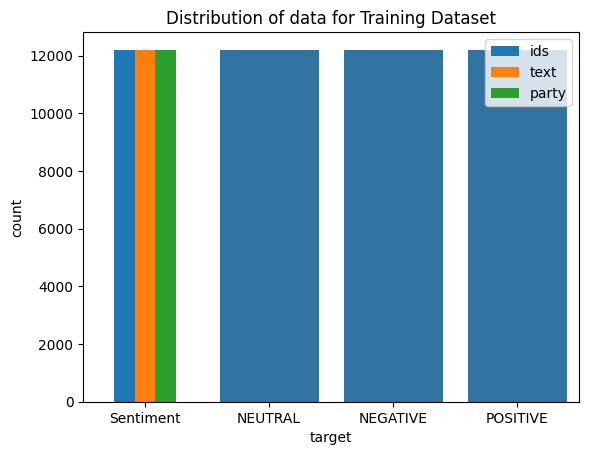

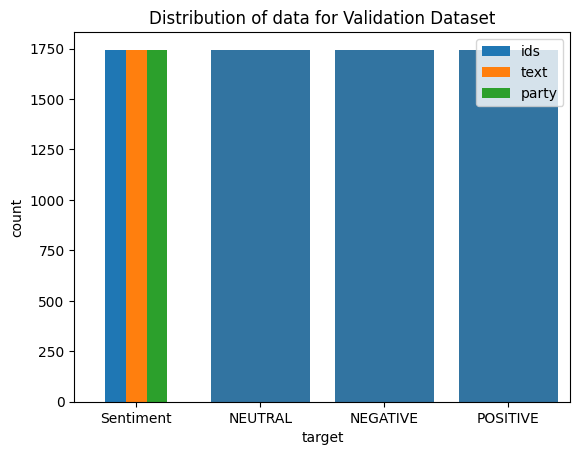

In [3]:
print("\n -------------- --- Data Process --- ----------------\n")


# Dataset encoding and columns names
DATASET_COLUMNS=['ids','text','target','party']
DATASET_ENCODING = "UTF-8"

# Reading train and valid set and adding both on a DataFrame (df)
df = pd.read_csv('train_set.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df2 = pd.read_csv('valid_set.csv',encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

print(" --- Csv files are readed --- ")

# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data for Training Dataset',legend=False)
ax.set_xticklabels(['Sentiment','NEUTRAL','NEGATIVE','POSITIVE'], rotation=0)

# Storing data in lists.
sns.countplot(x='target', data=df)

# Plotting the distribution for dataset.
ax = df2.groupby('target').count().plot(kind='bar', title='Distribution of data for Validation Dataset',legend=False)
ax.set_xticklabels(['Sentiment','NEUTRAL','NEGATIVE','POSITIVE'], rotation=0)

# Storing data in lists.
sns.countplot(x='target', data=df2)

print(" --- Cleaning started: Process 0% --- ")
df = total_cleaning(df)
print(" --- Training set Cleaning Completed: Process 80% --- ")
df2 = total_cleaning(df2)
print(" --- Valid set Cleaning Completed: Process 100% --- ")

print("\n ------------ --- Data Process Done --- --------------\n")


In [4]:
#   -------------- Model creation --------------   #

print("        --- Word2Vec ---        ")

train_dataset = df.iloc[1:]
valid_dataset= df2.iloc[1:]

w2v_model = Word2Vec(sentences=train_dataset['text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)   #  Train a Word2Vec model on the subsampled text  #
w2v_model.save("word2vec_model.model") # save word2vec model

print(" --- Word2Vec model created --- ")
# -------------------------------------------------- #

        --- Word2Vec ---        
 --- Word2Vec model created --- 


In [ ]:
print("\n --- Preparing Train and Valid set --- \n")
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

print(" --- Getting embeddings --- ")
train_dataset.loc[:, 'word_embeddings'] = train_dataset['text'].apply(lambda x: get_embeddings(x, w2v_model))
valid_dataset.loc[:, 'word_embeddings'] = valid_dataset['text'].apply(lambda x: get_embeddings(x, w2v_model))

train_dataset = train_dataset.dropna(subset=['word_embeddings'])
valid_dataset = valid_dataset.dropna(subset=['word_embeddings'])

train_labels = train_dataset['target']
valid_labels = valid_dataset['target']

print(" --- Tensor Use --- ")
train_features = torch.stack([torch.tensor(embedding) for embedding in train_dataset['word_embeddings'].dropna().tolist()])

label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(train_dataset['target'].dropna()), dtype=torch.long)

valid_features = torch.stack([torch.tensor(embedding) for embedding in valid_dataset['word_embeddings'].dropna().tolist()])
valid_labels = torch.tensor(label_encoder.transform(valid_dataset['target'].dropna()), dtype=torch.long)

# Create DataLoader for batch processing
print(" --- Creating Tensor Datasets --- ")
train_data = TensorDataset(train_features, train_labels)
valid_data = TensorDataset(valid_features, valid_labels)

print(" --- Creating the Loaders using DataLoader --- ")
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

print("\n --- Train and Valid set are ready to be used on our SentimentClassifier model --- \n")
    

In [6]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.selu = nn.SELU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.rnn(x)
        hidden = self.batch_norm(hidden[-1, :])
        hidden = self.selu(hidden.squeeze(0))  # Squeeze to remove the singleton dimension
        output = self.fc(hidden)
        return output
    
# Define model and optimizer
embedding_dim = 128  # Size of Word2Vec embeddings
hidden_dim = 64 # Size of the hidden state
output_dim = 3  # Number of classes (positive, negative, neutral)            

criterion = nn.CrossEntropyLoss()

In [ ]:
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n --- Using optuna to find the best parameters for our model --- \n")

def objective(trial):
    # Define hyperparameters to be optimized
    embedding_dim = trial.suggest_int('embedding_dim', 50, 300)
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)

    # Create model with suggested hyperparameters
    model = SentimentClassifier(embedding_dim, hidden_dim, output_dim)
    model.to(device)

    # Define optimizer with suggested learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 10
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    # Validation
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0

        for batch in valid_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)

            outputs = model(embeddings.unsqueeze(1))
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = correct_val / total_val

    return val_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f"\n --- Best Hyperparameters: {best_params} --- \n")

# Use the best hyperparameters to train the final model
best_embedding_dim = best_params['embedding_dim']
best_hidden_dim = best_params['hidden_dim']
best_learning_rate = best_params['learning_rate']

final_model = SentimentClassifier(best_embedding_dim, best_hidden_dim, output_dim)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_learning_rate)


In [8]:
# Lists to store training and validation metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = final_model
optimizer = final_optimizer

model.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10
print(" --- Training the model ---")
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    correct_train = 0
    total_train = 0

    train_all_labels = []
    train_all_predictions = []

    for batch in train_loader:
        embeddings, labels = batch
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_all_labels.extend(labels.cpu().numpy())
        train_all_predictions.extend(predicted.cpu().numpy())

    train_loss = sum(epoch_train_losses) / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    print(" --- Check the model using validation set ---")
    with torch.no_grad():
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0

        valid_all_labels = []
        valid_all_predictions = []
        all_labels = []
        all_predictions = []

        for batch in valid_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)

            outputs = model(embeddings.unsqueeze(1))
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            valid_all_labels.extend(labels.cpu().numpy())
            valid_all_predictions.extend(predicted.cpu().numpy())
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
        
        # Convert continuous values to integers (if needed)
        all_labels = np.round(all_labels).astype(int)
        all_predictions = np.round(all_predictions).astype(int)

        val_loss = epoch_val_loss / len(valid_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, '
              f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


 --- Training the model ---
 --- Check the model using validation set ---
Epoch 1/10, Train Loss: 1.1080463200572497, Train Accuracy: 0.3583148437286, Validation Loss: 1.093852044614546, Validation Accuracy: 0.3723035439137134
 --- Check the model using validation set ---
Epoch 2/10, Train Loss: 1.0933124208324945, Train Accuracy: 0.3710247349823322, Validation Loss: 1.0895123386675596, Validation Accuracy: 0.3717257318952234
 --- Check the model using validation set ---
Epoch 3/10, Train Loss: 1.0919314334520012, Train Accuracy: 0.37031254280001097, Validation Loss: 1.087477786409343, Validation Accuracy: 0.3852080123266564
 --- Check the model using validation set ---
Epoch 4/10, Train Loss: 1.090023948005372, Train Accuracy: 0.3746130879009505, Validation Loss: 1.0849732248329678, Validation Accuracy: 0.3915639445300462
 --- Check the model using validation set ---
Epoch 5/10, Train Loss: 1.0895840398686483, Train Accuracy: 0.3729421754731969, Validation Loss: 1.087682194505001, Val

In [10]:
################## f1 scores #####################
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Calculate F1-score for training set
train_f1 = f1_score(train_all_labels, train_all_predictions, average='weighted')
print(f"Training F1-Score: {train_f1:.4f}")

# Print classification report for training set
print("Training Classification Report:")
print(classification_report(train_all_labels, train_all_predictions))

# Print confusion matrix for training set
print("Training Confusion Matrix:")
print(confusion_matrix(train_all_labels, train_all_predictions))

# Calculate F1-score for validation set
valid_f1 = f1_score(valid_all_labels, valid_all_predictions, average='weighted')
print(f"Validation F1-Score: {valid_f1:.4f}")

# Print classification report for validation set
print("Validation Classification Report:")
print(classification_report(valid_all_labels, valid_all_predictions))

# Print confusion matrix for validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(valid_all_labels, valid_all_predictions))

Training F1-Score: 0.3719
Training Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.54      0.44     12177
           1       0.38      0.25      0.30     12162
           2       0.39      0.35      0.37     12168

    accuracy                           0.38     36507
   macro avg       0.38      0.38      0.37     36507
weighted avg       0.38      0.38      0.37     36507

Training Confusion Matrix:
[[6635 2394 3148]
 [5633 3026 3503]
 [5388 2515 4265]]
Validation F1-Score: 0.3737
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.64      0.48      1731
           1       0.40      0.24      0.30      1728
           2       0.42      0.29      0.35      1733

    accuracy                           0.39      5192
   macro avg       0.40      0.39      0.37      5192
weighted avg       0.40      0.39      0.37      5192

Validation Confusion Matrix:
[[1114 

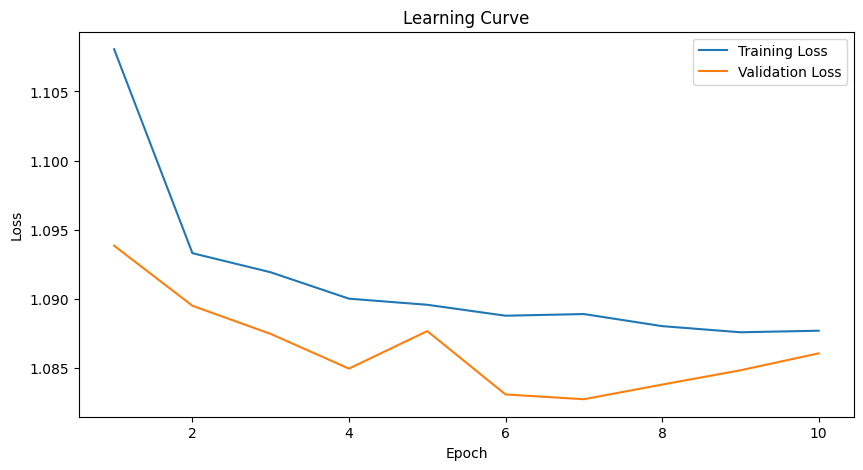

In [11]:

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

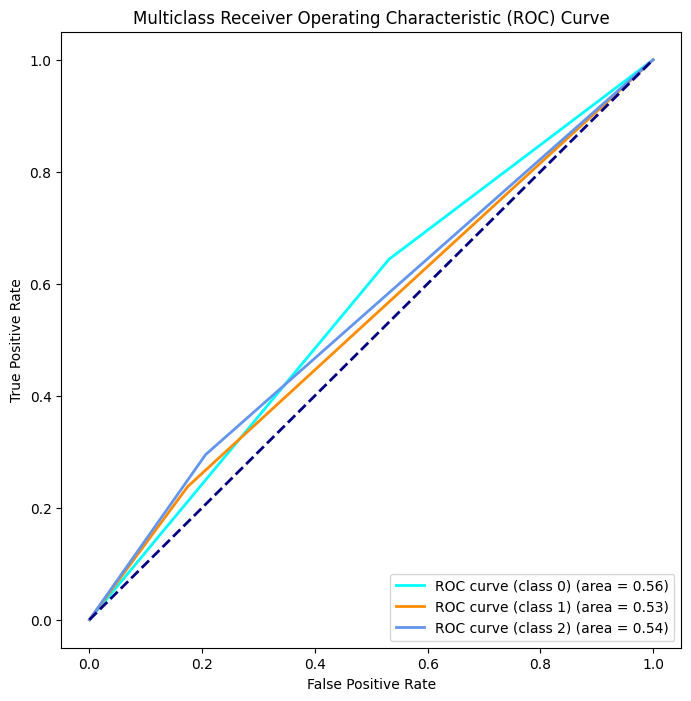

In [12]:
# # Plot ROC curve

# Compute ROC curve and ROC area for each class
# Convert continuous values to integers (if needed)
all_labels = np.round(all_labels).astype(int)
all_predictions = np.round(all_predictions).astype(int)

# Convert labels and predictions to one-hot encoding
all_labels_onehot = np.eye(output_dim)[all_labels]
all_predictions_onehot = np.eye(output_dim)[all_predictions]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_dim):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], all_predictions_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(output_dim), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


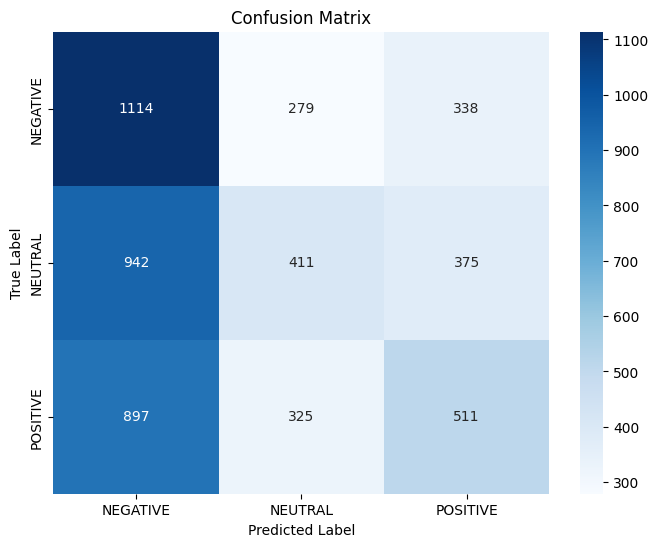

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert continuous values to integers (if needed)
all_labels = np.round(all_labels).astype(int)
all_predictions = np.round(all_predictions).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [59]:
DATASET_COLUMNS=['New_ID','text','party']
DATASET_ENCODING = "UTF-8"
test_dataset = pd.read_csv('test_set.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
test_dataset = test_dataset[1:]
test_dataset.fillna("", inplace=True)

test_dataset = total_cleaning(test_dataset)                                                    #  <- Make sumsamble for the word2vec             #


In [60]:
# Test set

test_dataset.loc[:, 'word_embeddings'] = test_dataset['text'].apply(lambda x: get_embeddings(x, w2v_model))

# Drop rows with missing word embeddings
test_dataset['word_embeddings'] = test_dataset['word_embeddings'].fillna(method='ffill')
test_dataset = test_dataset.dropna(subset=['word_embeddings'])

# Create features tensor for the test set
test_features = torch.stack([torch.tensor(embedding) for embedding in test_dataset['word_embeddings'].dropna().tolist()])

# # Create DataLoader for batch processing
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Make predictions on the test set
test_predictions = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        embeddings = batch[0].to(device)
        outputs = model(embeddings.unsqueeze(1))
        i , predicted = torch.max(outputs, 1)
        predicted = label_encoder.inverse_transform(predicted.numpy())
        test_predictions.extend(predicted)

test_dataset['party'] = test_predictions

result_df = pd.DataFrame({'Id': test_dataset.New_ID, 'Predicted': test_predictions})

# Save the result to a new CSV file
result_df.to_csv('submission.csv', index=False)
print(" -------------------------- New CSV edited and submission created ----------------- ")

# Now 'predictions' contains the predicted sentiment labels for your test set. I passed it

C:\Users\theodoros.minaidis\AppData\Local\Temp\ipykernel_7384\281395576.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_dataset['word_embeddings'] = test_dataset['word_embeddings'].fillna(method='ffill')


 -------------------------- New CSV edited and submission created ----------------- 


In [53]:
# Usefull orders

# -- installation -- #
# pip install torch  #
# pip install gensim #
# pip install optuna #
